# Pipeline BaseLine: YOLO -> Bounding Boxes -> Translation (Pinhole Camera Model) -> Resnet -> 6D Pose 


> Approccio base citato dalla prof su Discord

## 1. Import e Setup

In [ ]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import pandas as pd
import os
from torch.utils.data import DataLoader

# Importa il config e utilities
sys.path.insert(0, str(Path.cwd().parent))  # Aggiungi parent al path
from config import Config
from models.pose_estimator_baseline import PoseEstimatorBaseline
from models.yolo_detector import YOLODetector
from utils.pinhole import load_camera_intrinsics, compute_translation_pinhole
from utils.transforms import quaternion_to_rotation_matrix_batch
from dataset.linemod_pose import create_pose_dataloaders
from models.pose_estimator_baseline import PoseEstimatorBaseline
from utils.metrics import compute_add_batch_rotation_only, load_all_models, load_models_info
from utils.transforms import quaternion_to_rotation_matrix_batch
from utils.metrics import compute_add_batch_rotation_only
from utils.pinhole import load_camera_intrinsics, compute_translation_pinhole
from dataset.linemod_pose import LineMODPoseDataset



# Usa PROJECT_ROOT dal config
project_root = Config.PROJECT_ROOT
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Configura matplotlib per notebook
%matplotlib inline

print(f"✅ Setup completato (BASELINE MODEL)")
print(f"📂 Project root: {project_root}")
print(f"🎯 Dataset: LineMOD")
print(f"🖥️  Device: {Config.DEVICE}")
print(f"📊 Image size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"\n🔧 Baseline Configuration:")
print(f"   Translation: Pinhole Camera Model (geometric)")
print(f"   Rotation: ResNet50 → Quaternion (learned)")
print(f"   Depth: Required for Pinhole computation")

Cache Strategy: partial
Numworkers set to 0
Numworkers set to 0
✅ Setup completato (BASELINE MODEL)
📂 Project root: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation
🎯 Dataset: LineMOD
🖥️  Device: mps
📊 Image size: 224x224

🔧 Baseline Configuration:
   Translation: Pinhole Camera Model (geometric)
   Rotation: ResNet50 → Quaternion (learned)
   Depth: Required for Pinhole computation


In [ ]:
# Carica dataset con split ufficiale train/test (LineMODPoseDataset)
print("📦 Caricamento LineMODPoseDataset con split ufficiale...\n")

train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE
)

print(f"✅ Dataset caricato:")
print(f"   Train batches: {len(train_loader)} (batch_size={Config.POSE_BATCH_SIZE})")
print(f"   Test batches: {len(test_loader)}")
print(f"   Train samples: ~{len(train_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Test samples: ~{len(test_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Crop margin: {Config.POSE_CROP_MARGIN * 100:.0f}%")
print(f"   Output size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"   Workers: {Config.NUM_WORKERS_POSE} (adaptive per {Config.DEVICE})")

📦 Caricamento LineMODPoseDataset con split ufficiale...

✅ Dataset caricato:
   Train batches: 38 (batch_size=64)
   Test batches: 210
   Train samples: ~2432
   Test samples: ~13440
   Crop margin: 15%
   Output size: 224x224
   Workers: 0 (adaptive per mps)


## 2. Carica Modelli Pre-Trained

In [3]:
# ====== CARICAMENTO MODELLI ======

# 1. YOLO Fine-tuned per detection
print("=" * 60)
print("📦 CARICAMENTO YOLO DETECTOR")
print("=" * 60)

#YOLO_MODEL = f'yolo_train{Config.YOLO_EPOCHS}'
#yolo_weights = Config.CHECKPOINT_DIR / 'yolo' / YOLO_MODEL / 'weights' / 'best.pt'

yolo_weights = Config.CHECKPOINT_DIR / 'pretrained' / 'yolo11n.pt'

if yolo_weights.exists():
    print(f"✅ Carico YOLO: {yolo_weights.relative_to(project_root)}\n")
    yolo_detector = YOLODetector(
        model_name=str(yolo_weights),
        num_classes=Config.NUM_CLASSES
    )
    print(f"✅ YOLO caricato con successo!\n")
else:
    print(f"❌ YOLO weights non trovati: {yolo_weights}")
    print(f"   Allena prima YOLO (vedi test3_yolo2_finetuning.ipynb)\n")
    yolo_detector = None

# 2. PoseEstimatorBaseline (ResNet50) per rotation
print("=" * 60)
print("📦 CARICAMENTO POSE ESTIMATOR BASELINE (ResNet50 - Rotation Only)")
print("=" * 60)

# TODO: Al momento usa modello non trained, dopo training baseline aggiorna qui
BASELINE_MODEL = f"test_rotationonly_1"  # Da creare dopo training
checkpoint_dir = project_root / 'checkpoints' / 'pose' / BASELINE_MODEL
checkpoint_path = checkpoint_dir / 'weights' / 'best.pt'

# Inizializza modello baseline
model_baseline = PoseEstimatorBaseline(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False
).to(Config.DEVICE)

# Carica weights se esistono
if checkpoint_path.exists():
    print(f"\n✅ Carico checkpoint: {checkpoint_path.relative_to(project_root)}")
    checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE)
    # Gestione robusta: se il checkpoint è solo i pesi, carica direttamente
    if 'model_state_dict' in checkpoint:
        model_baseline.load_state_dict(checkpoint['model_state_dict'])
    else:
        model_baseline.load_state_dict(checkpoint)
    model_baseline.eval()
    
    print(f"📊 Checkpoint info:")
    print(f"   Epoch: {checkpoint.get('epoch', 0) + 1}")
    print(f"   Loss (rotation): {checkpoint.get('loss', 0):.4f}")
    print(f"\n✅ PoseEstimatorBaseline caricato e in modalità eval!")
    print(f"✅ Modello inizializzato:")
    print(f"   Backbone: ResNet-50 (pretrained ImageNet)")
    print(f"   Dropout: {Config.POSE_DROPOUT}")
    print(f"   Output: 4D quaternion (rotazione)")
    total_params = sum(p.numel() for p in model_baseline.parameters())
    trainable_params = sum(p.numel() for p in model_baseline.parameters() if p.requires_grad)
    print(f"\n📊 Parametri del modello:")
    print(f"   Parametri totali: {total_params:,}")
    print(f"   Parametri trainable: {trainable_params:,}")
    print(f"   Percentuale trainable: {100 * trainable_params / total_params:.1f}%")
else:
    print(f"\n⚠️  Checkpoint non trovato: {checkpoint_path}")
    print(f"   Usando modello con solo pretrained ImageNet weights")
    print(f"   Per risultati ottimali, allena prima il baseline model")
    print(f"   (vedi train_pose_baseline.py)\n")
    model_baseline.eval()

# Riepilogo modelli caricati
print("\n" + "=" * 60)
print("📋 RIEPILOGO MODELLI CARICATI")
print("=" * 60)
print(f"YOLO Detector:          {'✅ Caricato' if yolo_detector is not None else '❌ Non disponibile'}")
print(f"PoseEstimatorBaseline:  ✅ Caricato")
print(f"\n💡 Pipeline Baseline:")
print(f"   YOLO → Bbox → Pinhole (translation) → ResNet (rotation) → 6D Pose")
if yolo_detector is not None:
    print(f"\n🚀 Tutto pronto per la pipeline baseline!")
else:
    print(f"\n⚠️  YOLO mancante. Verifica i checkpoint.")
print("=" * 60)

📦 CARICAMENTO YOLO DETECTOR
✅ Carico YOLO: checkpoints/pretrained/yolo11n.pt

✅ Loading custom weights from: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pretrained/yolo11n.pt
✅ YOLO caricato con successo!

📦 CARICAMENTO POSE ESTIMATOR BASELINE (ResNet50 - Rotation Only)


/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimatorBaseline initialized (BASELINE MODEL)
   Backbone: resnet50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 4 values (quaternion only)
   Translation: Computed with Pinhole Camera Model (NOT learned)
   Dropout: 0.5

✅ Carico checkpoint: checkpoints/pose/test_rotationonly_1/weights/best.pt
📊 Checkpoint info:
   Epoch: 1
   Loss (rotation): 0.0000

✅ PoseEstimatorBaseline caricato e in modalità eval!
✅ Modello inizializzato:
   Backbone: ResNet-50 (pretrained ImageNet)
   Dropout: 0.5
   Output: 4D quaternion (rotazione)

📊 Parametri del modello:
   Parametri totali: 26,136,132
   Parametri trainable: 26,136,132
   Percentuale trainable: 100.0%

📋 RIEPILOGO MODELLI CARICATI
YOLO Detector:          ✅ Caricato
PoseEstimatorBaseline:  ✅ Caricato

💡 Pipeline Baseline:
   YOLO → Bbox → Pinhole (translation) → ResNet (rotation) → 6D Pose

🚀 Tutto pronto per la pipeline baseline!


## 3. Pipeline Baseline: YOLO Detection + Pinhole Translation + ResNet Rotation

Test della pipeline baseline conforme alle specifiche:
1. **YOLO11n** rileva oggetti e bbox
2. **Pinhole Camera Model** calcola translation da bbox + depth
3. **ResNet Baseline** predice rotation (quaternion)
4. Combina per ottenere **6D pose completa**

In [4]:
# Usa LineMODPoseDataset per pipeline pinhole+deep (dataset ufficiale)


# Crea test_loader con il dataset ufficiale LineMODPoseDataset
test_dataset = LineMODPoseDataset(
    dataset_root=Config.LINEMOD_ROOT,
    split='test',
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE
)
test_loader = DataLoader(
    test_dataset,
    batch_size=Config.POSE_BATCH_SIZE,
    shuffle=False,
    num_workers=Config.NUM_WORKERS_POSE,
    pin_memory=Config.PIN_MEMORY,
    persistent_workers=Config.NUM_WORKERS_POSE > 0
)

models_dict = load_all_models()
models_info = load_models_info(Config.MODELS_INFO_PATH)

all_pred_quaternions = []
all_gt_quaternions = []
all_obj_ids = []
all_pred_translations = []
all_gt_translations = []

model_baseline.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Valutazione su test set"):
        images = batch['rgb_crop'].to(Config.DEVICE)
        gt_quaternions = batch['quaternion'].to(Config.DEVICE)
        obj_ids = batch['obj_id'].cpu().numpy()
        pred_quaternions = model_baseline(images)
        all_pred_quaternions.append(pred_quaternions.cpu())
        all_gt_quaternions.append(gt_quaternions.cpu())
        all_obj_ids.append(obj_ids)
        
        # --- Calcolo translation con pinhole ---
        bboxes = batch['bbox'].cpu().numpy()  # [batch, 4]

        depth_paths = batch['depth_path']     # lista di path (stringhe)
        # Carica intrinseci (assume stesso oggetto in batch)
        
        camera_intrinsics = load_camera_intrinsics(
            os.path.join(os.path.dirname(depth_paths[0]), '../gt.yml')
        )
        pred_translations = []
        gt_translations = batch['translation'].cpu().numpy() if 'translation' in batch else None
        for i in range(len(bboxes)):
            try:
                pred_t = compute_translation_pinhole(bboxes[i], depth_paths[i], camera_intrinsics)
            except Exception as e:
                print(f"⚠️  Pinhole failed: {e}")
                pred_t = np.array([0.0, 0.0, 0.0], dtype=np.float32)
            pred_translations.append(pred_t)
        all_pred_translations.append(np.stack(pred_translations))
        if gt_translations is not None:
            all_gt_translations.append(gt_translations)

print("concatenazione batch")
all_pred_quaternions = torch.cat(all_pred_quaternions, dim=0)
all_gt_quaternions = torch.cat(all_gt_quaternions, dim=0)
all_obj_ids = np.concatenate(all_obj_ids, axis=0)
all_pred_translations = np.concatenate(all_pred_translations, axis=0)
if all_gt_translations:
    all_gt_translations = np.concatenate(all_gt_translations, axis=0)
else:
    all_gt_translations = None

print("conversione da quaternoni a matrici di rotazione")
pred_R = quaternion_to_rotation_matrix_batch(all_pred_quaternions)
gt_R = quaternion_to_rotation_matrix_batch(all_gt_quaternions)

print("calcolo metriche: 1) solo rotazione (ADD rot-only), 2) traslazione pinhole (statistiche)")
# 1. ADD solo rotazione (traslazione dummy)
results_rot_only = compute_add_batch_rotation_only(
    pred_R, gt_R, all_obj_ids, models_dict, models_info
)
results_rot_only['obj_ids'] = all_obj_ids

# 2. Statistiche traslazione pinhole (vs GT)
results_pinhole = {}
if all_gt_translations is not None:
    pinhole_errors = np.linalg.norm(all_pred_translations - all_gt_translations, axis=1)
    results_pinhole['obj_ids'] = all_obj_ids
    results_pinhole['pinhole_errors'] = pinhole_errors
    results_pinhole['pred_translations'] = all_pred_translations
    results_pinhole['gt_translations'] = all_gt_translations
else:
    results_pinhole = None
print("✅ Calcolate metriche: 1) ADD rot-only, 2) errori traslazione pinhole.")

✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points


Valutazione su test set:  63%|██████▎   | 133/210 [01:51<01:04,  1.19it/s]

⚠️  Pinhole failed: Invalid bbox after clipping: [117, 103, 117, 134]


Valutazione su test set:  81%|████████▏ | 171/210 [02:23<00:33,  1.17it/s]

⚠️  Pinhole failed: Invalid bbox after clipping: [229, 93, 229, 140]


Valutazione su test set: 100%|██████████| 210/210 [02:56<00:00,  1.19it/s]


concatenazione batch
conversione da quaternoni a matrici di rotazione
calcolo metriche: 1) solo rotazione (ADD rot-only), 2) traslazione pinhole (statistiche)
✅ Calcolate metriche: 1) ADD rot-only, 2) errori traslazione pinhole.


## 4. Statistiche per Classe: Traslazione (Pinhole) e Rotazione (ResNet)

Questa sezione mostra le performance della pipeline baseline per ciascuna classe: media errore di traslazione (mm), media errore di rotazione (deg), e la distribuzione degli errori. Le classi senza predizioni sono indicate con '–'.

### Tabella: Media ADD e Accuracy per Classe

La tabella seguente riporta la media dell'errore ADD e l'accuracy (percentuale di pose corrette) per ciascuna classe (oggetto) del dataset LineMOD.

In [7]:
# Tabella 1: Performance rotazione (ADD solo rotazione, traslazione dummy)
results_rot_only = globals().get('results_rot_only', None)
if results_rot_only is None:
    print("⚠️  Devi prima calcolare la metrica ADD rot-only su tutto il test set e salvare i risultati in 'results_rot_only'.")
else:
    obj_ids = np.array(results_rot_only['obj_ids'])
    add_values = np.array(results_rot_only['add_values'])
    is_correct = np.array(results_rot_only['is_correct'])
    data = []
    for obj_id, obj_name in Config.LINEMOD_OBJECTS.items():
        mask = obj_ids == obj_id
        if np.sum(mask) == 0:
            continue
        mean_add = add_values[mask].mean()
        acc = is_correct[mask].mean() * 100
        data.append({
            'Classe': f"{obj_id:02d} - {obj_name.get('name')}",
            'Media ADD (rot-only)': f"{mean_add:.2f}",
            'Accuracy (%)': f"{acc:.1f}"
        })
    df = pd.DataFrame(data)
    display(df)
    print("\nMedia globale ADD (rot-only):", f"{add_values.mean():.2f}")
    print("Accuracy globale (rot-only) (%):", f"{is_correct.mean()*100:.1f}")

# Tabella 2: Statistiche traslazione pinhole
results_pinhole = globals().get('results_pinhole', None)
if results_pinhole is None:
    print("⚠️  Devi prima calcolare le statistiche di traslazione pinhole e salvarle in 'results_pinhole'.")
else:
    obj_ids = np.array(results_pinhole['obj_ids'])
    pinhole_errors = np.array(results_pinhole['pinhole_errors'])
    data = []
    for obj_id, obj_name in Config.LINEMOD_OBJECTS.items():
        mask = obj_ids == obj_id
        if np.sum(mask) == 0:
            continue
        mean_pinhole = pinhole_errors[mask].mean()
        data.append({
            'Classe': f"{obj_id:02d} - {obj_name.get('name')}",
            'Err. Pinhole medio (mm)': f"{mean_pinhole:.2f}"
        })
    df_pinhole = pd.DataFrame(data)
    display(df_pinhole)
    print("\nErrore medio pinhole globale (mm):", f"{pinhole_errors.mean():.2f}")

,Classe,Media ADD (rot-only),Accuracy (%)
0,01 - ape,21.93,17.9
1,02 - benchvise,51.31,20.0
2,04 - camera,42.73,17.4
3,05 - can,52.80,12.4
4,06 - cat,28.75,22.5
5,08 - driller,19.06,86.7
6,09 - duck,28.55,9.9
7,10 - eggbox,49.63,12.0
8,11 - glue,30.28,18.8
9,12 - holepuncher,33.54,21.3



Media globale ADD (rot-only): 39.04
Accuracy globale (rot-only) (%): 21.1


,Classe,Err. Pinhole medio (mm)
0,01 - ape,875.97
1,02 - benchvise,752.79
2,04 - camera,871.29
3,05 - can,871.07
4,06 - cat,891.06
5,08 - driller,860.26
6,09 - duck,883.06
7,10 - eggbox,869.91
8,11 - glue,889.69
9,12 - holepuncher,891.08



Errore medio pinhole globale (mm): 876.83


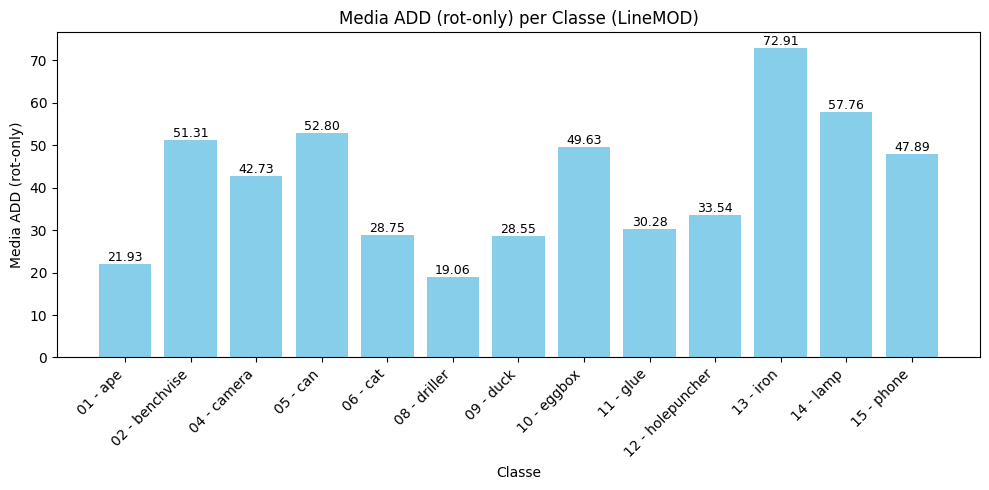

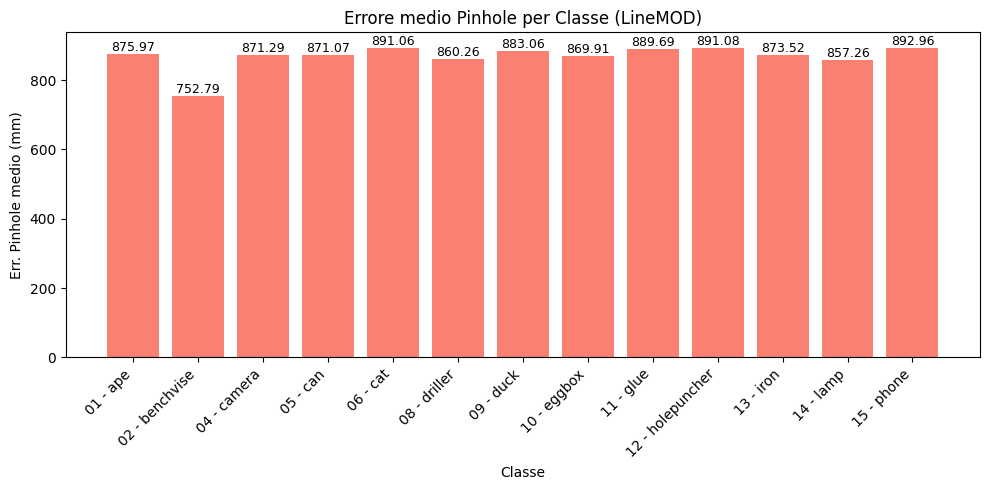

In [8]:
# Grafico a barre delle medie ADD per classe (rot-only)
results_rot_only = globals().get('results_rot_only', None)
if results_rot_only is None:
    print("⚠️  Devi prima calcolare la metrica ADD rot-only su tutto il test set e salvare i risultati in 'results_rot_only'.")
else:
    obj_ids = np.array(results_rot_only['obj_ids'])
    add_values = np.array(results_rot_only['add_values'])
    class_names = []
    mean_adds = []
    for obj_id, obj_name in Config.LINEMOD_OBJECTS.items():
        mask = obj_ids == obj_id
        if np.sum(mask) == 0:
            continue
        class_names.append(f"{obj_id:02d} - {obj_name.get('name')}")
        mean_adds.append(add_values[mask].mean())
    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_names, mean_adds, color='skyblue')
    plt.ylabel('Media ADD (rot-only)')
    plt.xlabel('Classe')
    plt.title('Media ADD (rot-only) per Classe (LineMOD)')
    plt.xticks(rotation=45, ha='right')
    for bar, value in zip(bars, mean_adds):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

# Grafico a barre dell'errore medio pinhole per classe
results_pinhole = globals().get('results_pinhole', None)
if results_pinhole is None:
    print("⚠️  Devi prima calcolare le statistiche di traslazione pinhole e salvarle in 'results_pinhole'.")
else:
    obj_ids = np.array(results_pinhole['obj_ids'])
    pinhole_errors = np.array(results_pinhole['pinhole_errors'])
    class_names = []
    mean_pinhole = []
    for obj_id, obj_name in Config.LINEMOD_OBJECTS.items():
        mask = obj_ids == obj_id
        if np.sum(mask) == 0:
            continue
        class_names.append(f"{obj_id:02d} - {obj_name.get('name')}")
        mean_pinhole.append(pinhole_errors[mask].mean())
    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_names, mean_pinhole, color='salmon')
    plt.ylabel('Err. Pinhole medio (mm)')
    plt.xlabel('Classe')
    plt.title('Errore medio Pinhole per Classe (LineMOD)')
    plt.xticks(rotation=45, ha='right')
    for bar, value in zip(bars, mean_pinhole):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()